### DATA PREDICTION MODEL: Cervical Cancer Binary Classification

##### Workflow:
1. Load preprocessed data
2. Split into training/testing sets
3. Scale features
4. Train multiple classification models
5. Evaluate models using metrics like Accuracy, Precision, Recall, F1 Score, AUC
6. Visualize confusion matrices and ROC curves
7. Compare model performance

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
"""TO READ FILE"""
import os
print("Current working directory is:", os.getcwd())

Current working directory is: c:\Users\chelyn\OneDrive - Nanyang Technological University\biohackathon\Biohackathon Materials\Cervical Cancer


In [3]:
#load cleaned data
clean_data = pd.read_csv('cleaned_cervical_cancer.csv')

In [4]:
#Define target variable
target = 'Dx'
X = clean_data.drop(columns=[target])
Y = clean_data[target]

In [5]:
#Split dataset into training and testing sets (80-20)
X_training, X_testing, Y_training, Y_testing = train_test_split(X, Y, test_size=0.2, random_state=42)

#Standardise features (important for SVM and Logistic Regression)
scaler = StandardScaler()
X_training_scaled = scaler.fit_transform(X_training)
X_testing_scaled = scaler.transform(X_testing)

In [ ]:
# possible weighting change based on the columns researched

# getting feature_idx for the features with more importance
feature_names = ["Dx:HPV", "Hormonal Contraceptives"]

for col in feature_names:
    feature_idx = X_training.columns.get_loc(col)

    X_training_scaled[:, feature_idx] *= 1.5
    X_testing_scaled[:, feature_idx] *= 1.5

28
7


### Possible MODELS:
- Logistic Regression (linear classifier, interpretable)
- Random Forest (ensemble method, handles non-linearity well)
- Support Vector Machine (robust with high-dimensional data)
- XGBoost (gradient boosting, powerful for structured data)

In [7]:
#Define models
models = {
    "Logistics Regression": LogisticRegression(class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced",random_state=42),
    "SVM": SVC(probability=True, class_weight="balanced"),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

### TRAIN & EVALUATE MODELS

In [8]:
#train + evaluate models
result = []
fitted_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_training_scaled, Y_training)
    fitted_models[name] = model

    Y_prediction = model.predict(X_testing_scaled)
    if hasattr(model, "predict_proba"):
        Y_probability = model.predict_proba(X_testing_scaled)[:, 1]
    else:
        Y_probability = None

    print(f"Results for {name}:")
    print(f"Accuracy: {accuracy_score(Y_testing, Y_prediction):.4f}")
    print(f"Precision: {precision_score(Y_testing, Y_prediction):.4f}")
    print(f"Recall: {recall_score(Y_testing, Y_prediction):.4f}")
    print(f"F1 Score: {f1_score(Y_testing, Y_prediction):.4f}")

    print(classification_report(Y_testing, Y_prediction))
    print("------------")

Training Logistics Regression...
Results for Logistics Regression:
Accuracy: 0.9817
Precision: 0.7143
Recall: 0.8333
F1 Score: 0.7692
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       158
           1       0.71      0.83      0.77         6

    accuracy                           0.98       164
   macro avg       0.85      0.91      0.88       164
weighted avg       0.98      0.98      0.98       164

------------
Training Random Forest...
Results for Random Forest:
Accuracy: 0.9939
Precision: 0.8571
Recall: 1.0000
F1 Score: 0.9231
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       158
           1       0.86      1.00      0.92         6

    accuracy                           0.99       164
   macro avg       0.93      1.00      0.96       164
weighted avg       0.99      0.99      0.99       164

------------
Training SVM...
Results for SVM:
Accuracy: 0.9817
Precision: 0.714

### Confusion Matrix
It shows how many True Positive, True Negatives, False Positive, True Positive for each model.

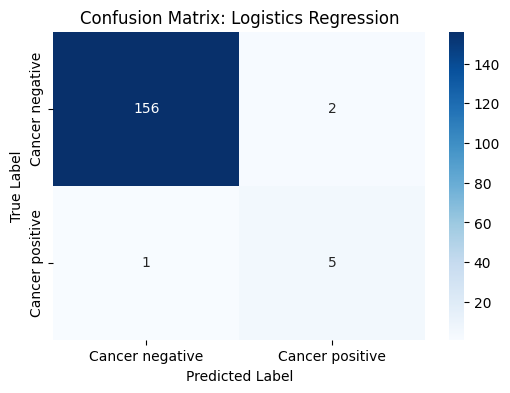

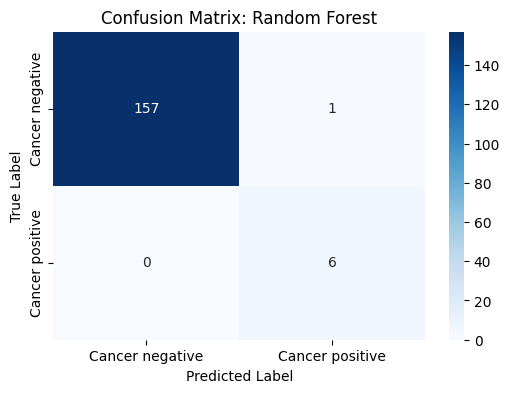

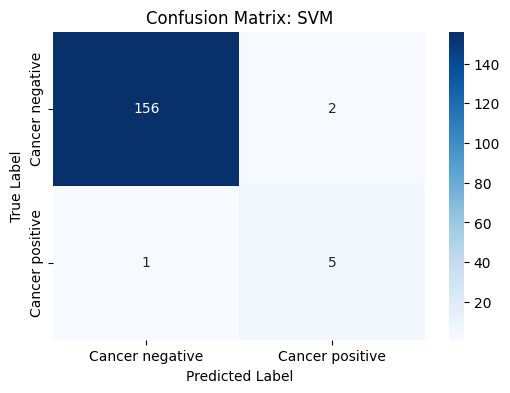

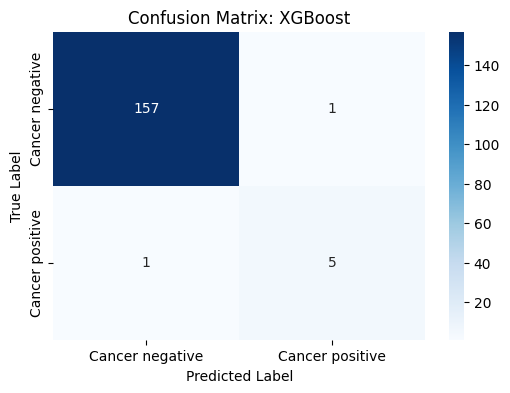

In [9]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
for name, model in fitted_models.items():
    Y_predicted = model.predict(X_testing_scaled)
    confusion_mtx = confusion_matrix(Y_testing, Y_predicted)
    
    #plot as heatmap for visualisation
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        confusion_mtx, 
        annot=True, 
        fmt='d', 
        cmap="Blues", 
        xticklabels=['Cancer negative', 'Cancer positive'], 
        yticklabels=['Cancer negative', 'Cancer positive']
    )
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### ROC Curve & AUC

ROC Curve: shows trade-off between TP rate(Recall) and FP rate

AUC (Area Under Curve): indicates how well a model can distinguish between classes

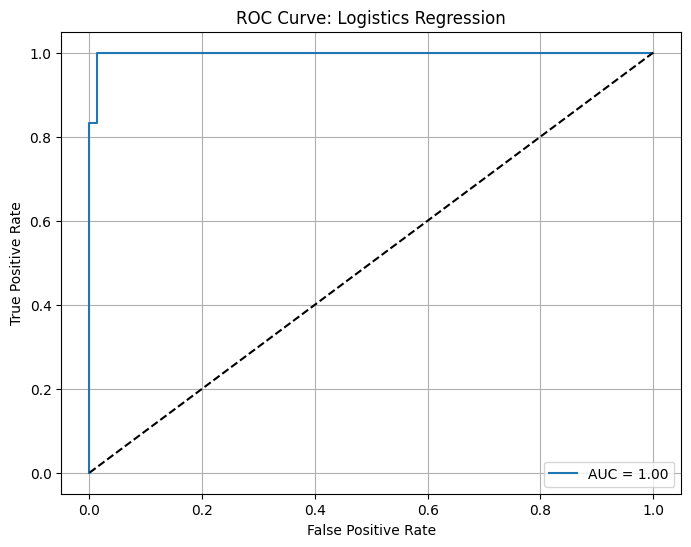

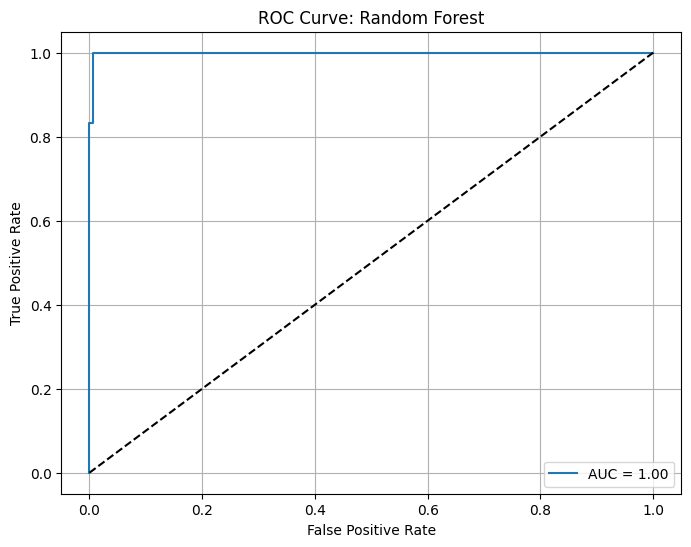

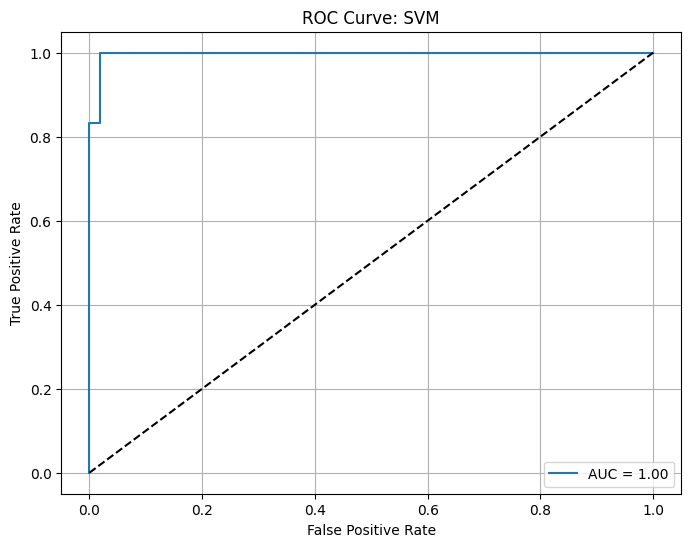

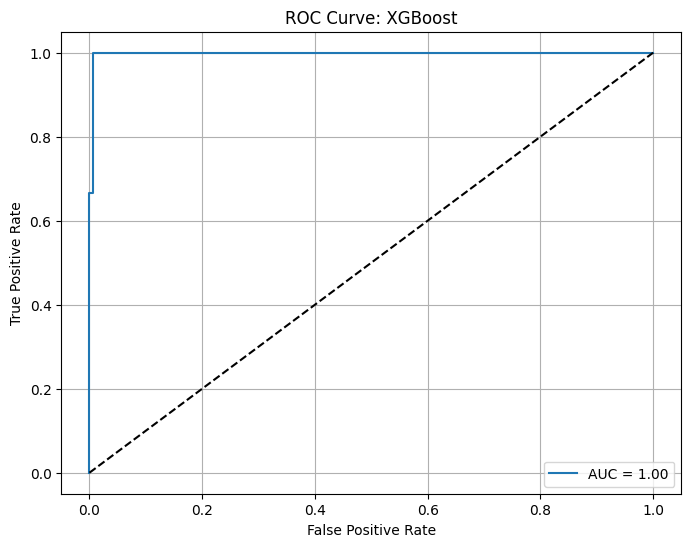

In [10]:
#ROC Curve
from sklearn.metrics import roc_curve, auc

for name, model in fitted_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_testing_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(Y_testing, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"ROC Curve: {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(True)
        plt.show()

### Model Performances
summerisation of all the evaluation metrics (Accuracy, Precision, Recall, F1 Score, AUC) in a DataFrame for easy comparison

In [11]:
from sklearn.metrics import roc_auc_score

metrics_summary = []

for name, model in fitted_models.items():
    y_pred = model.predict(X_testing_scaled)
    y_prob = model.predict_proba(X_testing_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    metrics_summary.append({
        "Model": name,
        "Accuracy": accuracy_score(Y_testing, y_pred),
        "Precision": precision_score(Y_testing, y_pred),
        "Recall": recall_score(Y_testing, y_pred),
        "F1 Score": f1_score(Y_testing, y_pred),
        "AUC": roc_auc_score(Y_testing, y_prob) if y_prob is not None else None
    })

results_df = pd.DataFrame(metrics_summary)
results_df = results_df.sort_values(by="Recall", ascending=False)
print(results_df)


                  Model  Accuracy  Precision    Recall  F1 Score       AUC
1         Random Forest  0.993902   0.857143  1.000000  0.923077  0.998945
0  Logistics Regression  0.981707   0.714286  0.833333  0.769231  0.997890
2                   SVM  0.981707   0.714286  0.833333  0.769231  0.996835
3               XGBoost  0.987805   0.833333  0.833333  0.833333  0.997890


### Model Comparisons:

Key evaluation metrics:
- **Recall (TP rate)** -- Avoid false negatives (don't want to miss positive cancer patients)
- **Precision** -- Avoid false positives (don't want to misjudge a healthy person as cancerous)
- **F1 Score** -- Balance between Precision & Recall
- **AUC** -- overall classification power at all thresholds


#### Observations:
- **Random Forest**: Top performance across all metrics
- **XGBoost**: Competitive performance, especially in terms of balanced precision and recall
- **Logistic Regression/SVM**: moderate performance across all metrics, low precision and F1 scores

##### Conclusion: Random Forest appears most promising


In [12]:
# actual prediction
rf_model = fitted_models["Random Forest"]
y_pred_rf = rf_model.predict(X_testing_scaled)
print(y_pred_rf)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


In [13]:
# saving of the model
import joblib
joblib.dump(rf_model, "random_forest_model.pkl")

['random_forest_model.pkl']